# 4. Dimensional Reduction
Compiled by [Morgan Williams](mailto:morgan.williams@csiro.au) for C3DIS 2018 

Geochemical data is commonly of high dimension, which interferes primarily with an ability to visualise a dataset, and thus peform exploratory data investigation. Importantly, a large amount of geological information can be recorded by relatively few geochemical components. Dimensional reduction may be a useful strategy for data visualisation, and would ideally allow an analyst to focus on a reduced number of parameters reflecting real geological trends and/or differences.

There are typically strong covariances within subset groups of elements, due to the similarities in physiochemical properties between geochemical components. This has been used in the past as a (generally valid) method of dimensional reduction (i.e. where one element is used as a proxy for a group). However, these element groups (especially the rare-earth elements) do exhibit systematic intra-group variation which encodes useful additional geochemical information.

## Principal Component Analysis

Principal component analysis is a commonly used method of dimensional reduction which - by formulation - retains maximum variance. Visualisation of principal components allows for more of the variance structure to be investigated relative to ternary diagrams. The data files used below are synthetic examples from Aitchison (1984).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import ternary

sys.path.insert(0, './src')
from compositions import *
from geochem import *
from plotting_tools import *

np.random.seed(int(''.join([str(ord(c)) for c in 'C3DIS']))//3)

In [3]:
fndir = r'data/examples/'
fns = ['boxite.xlsx', 'coxite.xlsx', 'hongite.xlsx', 'kongite.xlsx']
dfs = [pd.read_excel(os.path.join(fndir, f)) for f in fns]
[setattr(df, 'label', fns[ix]) for ix, df in enumerate(dfs)]
B, C, H, K = dfs

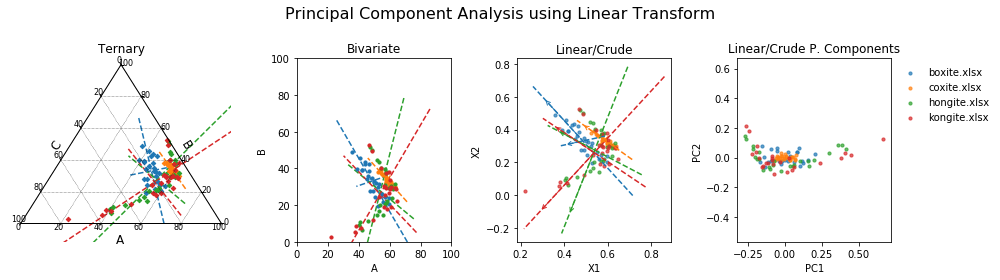

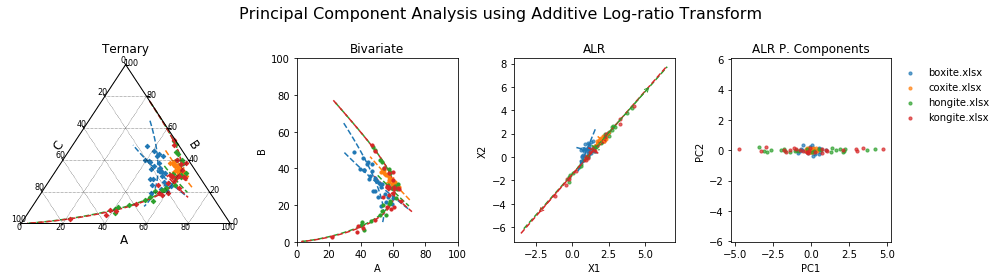

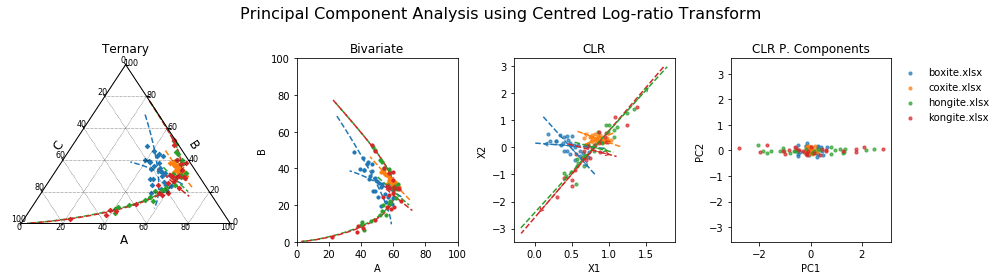

In [4]:
dvars = ['A', 'B', 'C']
markersize=10
TS = [LinearTransform, ALRTransform, CLRTransform]

pca = PCA(n_components=2)

for T, ix in zip(TS, range(4)):
    fig, ax = plt.subplots(1, 4, figsize=(14, 3.5), gridspec_kw = {'width_ratios':[1, 0.7, 0.7, 0.7]})
    f, tax = ternary.figure(ax=ax[0], scale=100)
    ax[0].set_title('Ternary')
    ax[1].set_xlim((0,100))
    ax[1].set_ylim((0,100))
    cleanup_ternary(tax)
    
    for df in [B, C, H, K]:
        data = df.loc[:, dvars].values[:, :3]
        data = close(data)       
        
        ax[1].set_xlabel(dvars[0])
        ax[1].set_ylabel(dvars[1])
        ax[1].set_title('Bivariate')
        ax[1].scatter(data[:, 0]*100, data[:, 1]*100, s=markersize)
        t = T()
        d = t.transform(data)
        ax[2].set_xlabel('X1')
        ax[2].set_ylabel('X2')
        scat = ax[2].scatter(d[:, 0], d[:, 1], alpha=0.7, label=df.label, s=markersize)
        ax[2].set_title(t.label)
        pca.fit(d)
        color=mcolors.to_hex(scat.get_facecolor()[0])
        for variance, vector in zip(pca.explained_variance_, pca.components_):
            v = vector[:2] * 3 * np.sqrt(variance)
            draw_vector(pca.mean_[:2],
                        pca.mean_[:2] + v,
                        ax=ax[2],
                        linewidth=1,
                        linestyle='--',
                        color=color)
            line = vector_to_line(pca.mean_, vector, variance, spans=4)
            ax[2].plot(line[:, 0], line[:, 1], color=color, ls='--', lw=1.5)
            
            line = t.inverse_transform(line)
            line = line * 100/line.sum(axis=1)[0]
            ax[1].plot(line[:, 0], line[:, 1], ls='--', lw=1.5, color=color, zorder=-1)
            tax.plot(line, ls='--', lw=1.5, color=color, zorder=-1)
            
        
        # plot principal components
        d_pca = pca.transform(d)
        ax[3].scatter(d_pca[:, 0], d_pca[:, 1], alpha=0.7, label=df.label, color=color, s=markersize)
        
        tax.scatter(data*100, marker='D', s=markersize, color=color)
        tax.bottom_axis_label("A", fontsize=12)     
        tax.right_axis_label("B", fontsize=12)
        tax.left_axis_label("C", fontsize=12)   
    
    ax[3].axis('equal')
    ax[3].set(xlabel='PC1', ylabel='PC2', title='{} P. Components'.format(t.label))

    ax[-1].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))
    fig.suptitle(f'Principal Component Analysis using {t.longlabel}', y=1.10, fontsize=16)
    plt.tight_layout()

## Deconvolving Mixtures

Identifying and quantifying geochemical mixing is a common problem in geology. Few rocks have 'ideal' compositions, and in reality the chemistry we sample represents mixutres of mixtures (with one of the early ones being the composition of our solar system!) - and deconvolving them can be difficult.

One principal issue which arises is the lack of endmembers - rocks commonly show a range of compositions which indicate mixing between two reservoirs may have occurred - but we don't always have good constraints on the endmembers themselves (more commonly, they're what we're tryping to back out).

This process is further complicated by the fact that to mix rock compositions (other than for sediments), specific and occasionally extreme geological processes are typically in operation (e.g. melting the base of the crust with a plume, large-scale subduction) - and any model of mixtures is unlikely to be valid unless 'offsets' due to geological processes are first quantified.

#### E.g. Polytypic Vector Analysis
See Szymanski et al (2013): Evaluating Complex Magma Mixing via Polytopic Vector Analysis (PVA) in the Papagayo Tuff, Northern Costa Rica: Processes that Form Continental Crust